Check running TensorFlow version

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

# Dogs vs. Cats

The goal is to build a system to distinguish dogs vs. dogs.

This was a [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats) back in 2013. I will only use a subset of the available dataset here:
- 2,000 for training, split 50% dogs - 50% cats
- 1,000 for validation, split 50% dogs - 50% cats
- 1,000 for test, split 50% dogs - 50% cats

Here I will measure the accuracy of a vanilla ConvNet model. I will also keep an eye for overfitting given the small size of the dataset. Later I will try to solve this problem differently and compare the results.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import matplotlib.pyplot as plt
%matplotlib inline

import random as rand

import numpy as np

import shutil

In [3]:
batch_size = 16

## Prepare the dataset

I manually downloaded the dataset from this [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats), unzipped it and here I will prepare for model training

In [4]:
data_path = Path("../data")
data_path.ls()

[PosixPath('../data/preprocessed')]

In [5]:
dogs_vs_cats_dir_name = "dogs-vs-cats"
raw_dir_name = "raw"
preprocessed_dir_name = "preprocessed"

train_dir_name = "train"
valid_dir_name = "valid"
test_dir_name = "test"

dogs_dir_name = "dogs"
cats_dir_name = "cats"

raw_data_path = data_path/raw_dir_name/dogs_vs_cats_dir_name
preprocessed_data_path = data_path/preprocessed_dir_name/dogs_vs_cats_dir_name

dogs_train_data_path = preprocessed_data_path/train_dir_name/dogs_dir_name
cats_train_data_path = preprocessed_data_path/train_dir_name/cats_dir_name

dogs_valid_data_path = preprocessed_data_path/valid_dir_name/dogs_dir_name
cats_valid_data_path = preprocessed_data_path/valid_dir_name/cats_dir_name

dogs_test_data_path = preprocessed_data_path/test_dir_name/dogs_dir_name
cats_test_data_path = preprocessed_data_path/test_dir_name/cats_dir_name

In [6]:
raw_data_path.ls()

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/dogs-vs-cats'

In [ ]:
(raw_data_path/"train").ls()[:5]

Create new directories

In [7]:
dogs_train_data_path.mkdir(parents=True, exist_ok=True)
cats_train_data_path.mkdir(parents=True, exist_ok=True)

dogs_valid_data_path.mkdir(parents=True, exist_ok=True)
cats_valid_data_path.mkdir(parents=True, exist_ok=True)

dogs_test_data_path.mkdir(parents=True, exist_ok=True)
cats_test_data_path.mkdir(parents=True, exist_ok=True)

Copy data over to preprocessed directory

In [8]:
raw_train_data_path = raw_data_path/"train"

def filter_files(key: str, path: Path): 
    return list(filter(lambda file_name: str(file_name).find(key) > 0, path.ls()))

dogs_files = filter_files("dog.", raw_train_data_path)
cats_files = filter_files("cat.", raw_train_data_path)
print(f"There are {len(dogs_files)} available dogs images, and {len(cats_files)} available cats images")

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/dogs-vs-cats/train'

In [9]:
def copy(files: list, start_index: int, end_index: int, dest: Path):
    for i in range(start_index, end_index):
        shutil.copy(files[i], dest)

# Train
copy(dogs_files, 0, 1000, dogs_train_data_path)
copy(cats_files, 0, 1000, cats_train_data_path)

# Valid
copy(dogs_files, 1000, 1500, dogs_valid_data_path)
copy(cats_files, 1000, 1500, cats_valid_data_path)

# Test
copy(dogs_files, 1500, 2000, dogs_test_data_path)
copy(cats_files, 1500, 2000, cats_test_data_path)

NameError: name 'dogs_files' is not defined

## Explore the data

In [10]:
rows = 3
cols = 3

plt.subplots_adjust(wspace=0, hspace=.3)
for i, index in enumerate(rand.choices(range(len(dogs_files)), k=rows*cols), 1):
    plt.subplot(rows, cols, i)
    plt.imshow(load_img(dogs_files[index], target_size=(150, 150)))

NameError: name 'dogs_files' is not defined

<Figure size 432x288 with 0 Axes>

In [11]:
plt.subplots_adjust(wspace=0, hspace=.3)
for i, index in enumerate(rand.choices(range(len(dogs_files)), k=rows*cols), 1):
    plt.subplot(rows, cols, i)
    plt.imshow(load_img(cats_files[index], target_size=(150, 150)))

NameError: name 'dogs_files' is not defined

<Figure size 432x288 with 0 Axes>

## Build data generators

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    preprocessed_data_path/train_dir_name,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = train_datagen.flow_from_directory(
    preprocessed_data_path/valid_dir_name,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = train_datagen.flow_from_directory(
    preprocessed_data_path/test_dir_name,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Check datagen outputs

In [13]:
image = load_img(dogs_files[0], target_size=(150, 150))
image_numpy = img_to_array(image)
x = image_numpy.reshape((1,) + image_numpy.shape)
x.shape

NameError: name 'dogs_files' is not defined

In [14]:
plt.imshow(image)

NameError: name 'image' is not defined

In [15]:
for i, batch in enumerate(train_datagen.flow(x, batch_size=1), 1):
    plt.subplot(2, 2, i)
    plt.imshow(array_to_img(batch[0]))
    
    if i == 4:
        break

NameError: name 'x' is not defined

## Train a basic ConvNet model

In [16]:
train_generator[0][0].shape[1:]

(150, 150, 3)

In [17]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [18]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
len(train_generator), len(valid_generator)

(125, 63)

In [20]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    use_multiprocessing=True
)
history.history.keys()

Epoch 1/50


W0820 03:08:20.607979 139914120209792 deprecation.py:323] From /home/jupyter/anaconda2/envs/keras/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


125/125 [==============================] - 30s 242ms/step - loss: 1.3558 - accuracy: 0.5090 - val_loss: 0.6956 - val_accuracy: 0.5070
Epoch 2/50
125/125 [==============================] - 27s 215ms/step - loss: 0.6991 - accuracy: 0.5300 - val_loss: 0.6879 - val_accuracy: 0.5650
Epoch 3/50
125/125 [==============================] - 27s 214ms/step - loss: 0.6965 - accuracy: 0.5475 - val_loss: 0.6812 - val_accuracy: 0.5380
Epoch 4/50
125/125 [==============================] - 26s 209ms/step - loss: 0.6919 - accuracy: 0.5655 - val_loss: 0.6604 - val_accuracy: 0.6120
Epoch 5/50
125/125 [==============================] - 27s 214ms/step - loss: 0.6814 - accuracy: 0.5840 - val_loss: 0.6682 - val_accuracy: 0.5950
Epoch 6/50
125/125 [==============================] - 27s 214ms/step - loss: 0.6686 - accuracy: 0.5975 - val_loss: 0.6535 - val_accuracy: 0.6050
Epoch 7/50
125/125 [==============================] - 27s 215ms/step - loss: 0.6555 - accuracy: 0.6200 - val_loss: 0.6430 - val_accuracy: 0.6

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

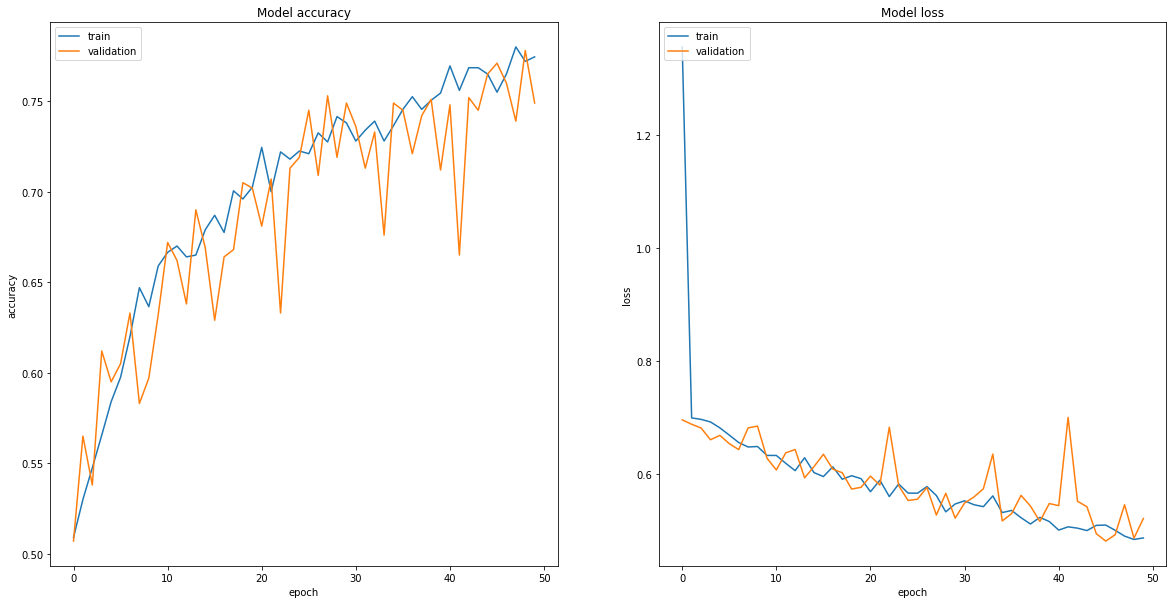

In [21]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Save the model

In [22]:
weights_path = Path("../weights")
weights_path.mkdir(parents=True, exist_ok=True)

In [23]:
model.save(weights_path/"dogs_vs_cats_v1.h5")